# Sentinel-1 Water History
This notebook will create a water history product similar to WOFS that shows the percent time a pixel has been water over the time series. 

In [1]:
# Ignore warnings 
import warnings
warnings.simplefilter('ignore')

# Load Data Cube Configuration
from odc_gee.earthengine import Datacube
dc = Datacube()

# Import Utilities
from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.dc_rgb import rgb
from utils.data_cube_utilities.raster_filter import stats_filter_2d
import folium
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Select data platform and product
# NOTE: Data from both Sentinel-1A and Sentinel-1B missions are included
platform = 'Sentinel-1A'
product = 's1_google'

## Define the Extents of the Analysis and View

In [3]:
# Villahermosa, Mexico
# lat_long = (17.9931, -92.9395)
# box_size_deg = 0.10

# Macuspana, Tabasco, Mexico
# Time = 2020-10-01, 2020-11-30
# Dry on 10-22, Flooded on 11-09
# lat_long = (17.713, -92.595)
# box_size_deg = 0.2

# Lake Salunga, Tanzania
# latitude = (-6.2936, -5.8306 ) 
# longitude = (34.9612, 35.3624 ) 

# Mtera Reservoir, Tanzania
latitude = (-7.2395, -6.8395)
longitude = (35.6377, 36.0377) 

# Suva, Fiji
# latitude = (-18.1725, -18.0492) 
# longitude = (178.3881, 178.5190) 

# Rewa River, Fiji
# latitude = (-18.1188, -18.0339) 
# longitude = (178.5107, 178.5869) 

# Tonle Sap Lake, Cambodia - southern tip, small region
# latitude = (12.31, 12.62 ) 
# longitude = (104.35, 104.71) 

In [4]:
time_extents = ('2021-01-01', '2021-12-31')

In [5]:
# Calculate the latitude and longitude bounds of the analysis box
# latitude = (lat_long[0]-box_size_deg/2, lat_long[0]+box_size_deg/2)
# longitude = (lat_long[1]-box_size_deg/2, lat_long[1]+box_size_deg/2)

In [16]:
resolution = 100.0
scale = resolution / 111320.0 

In [17]:
parameters = dict(product=product, platform=platform, measurements=['vv','vh'],
                  time=time_extents, lat=latitude, lon=longitude, group_by='solar_day',
                  output_crs='EPSG:4326', resolution=(-scale, scale), resampling='average',
                  query={'filter':'relativeOrbitNumber_start=28'})

In [18]:
f = folium.Figure(width=800, height=800)
m = display_map(latitude,longitude)
f.add_child(m)

## Load the data and apply filtering

In [19]:
sar_dataset = dc.load(**parameters)

In [20]:
# Filter Metadata

from operator import itemgetter

def get_metadata(group):
    metadata = (set(), set(), set(), set())
    for ds in group:
        metadata[0].add(np.datetime64(ds.metadata_doc.get('properties').get('dtr:start_datetime'), 'D'))
        metadata[1].add(ds.metadata_doc.get('properties').get('gee:properties').get('orbitProperties_pass'))
        metadata[2].add(ds.metadata_doc.get('properties').get('gee:properties').get('platform_number'))
        metadata[3].add(ds.metadata_doc.get('properties').get('gee:properties').get('relativeOrbitNumber_start'))
    return tuple(map(lambda x: ', '.join([str(i) for i in x]), metadata))

parameters.update(group_by='time' if not parameters.get('group_by') else parameters['group_by'])
sar_metadata = sorted([get_metadata(groups)
                       for groups in dc.group_datasets(dc.find_datasets(**parameters),
                                                       parameters.get('group_by')).values],
                      key=itemgetter(0))

## Data Summary
The table below summarizes the available Sentinel-1 data. You will find different acquisition dates, pass directions (ascending or descending), missions (A=Sentinel-1A, B=Sentinel-1B) and orbit path numbers. Finding flooding requires comparisons of images from similar viewing angles. So, it is important to only compare acquisitions with the same orbit path number. You will find that the same orbit number can come from two missions (6-day separation) or one mission (12-day separation) but the pass direction (ascending or descending) will be the same. 

In [21]:
# Show acquisition indices and dates
pd.set_option('display.max_rows', 250)
pd.DataFrame(sar_metadata, columns=['Acquisition Date', 'Pass Direction', 'Mission', 'Orbit Number'])

,Acquisition Date,Pass Direction,Mission,Orbit Number
0,2021-01-03,ASCENDING,A,28
1,2021-01-15,ASCENDING,A,28
2,2021-01-27,ASCENDING,A,28
3,2021-02-08,ASCENDING,A,28
4,2021-02-20,ASCENDING,A,28
5,2021-03-04,ASCENDING,A,28
6,2021-03-16,ASCENDING,A,28
7,2021-03-28,ASCENDING,A,28
8,2021-04-09,ASCENDING,A,28
9,2021-04-21,ASCENDING,A,28


### Speckle Filtering using a Block Average Filter
Radar data is often "grainy" in appearance due to speckle (statistical noise) and differences between water and land are not consistent. To improve the data, it is quite common to use speckle filtering. Below is an algorithm that uses a common "block averaging" filter to average the pixels surrounding any given pixel. Users can select an odd number filter window size (e.g. 3,5,7, etc.) to filter both the VV and VH data. A filter window size of 3 will average a 3x3 region around every pixel. Similarly, a filter window size of 5 will average a 5x5 region around a every pixel. 

In [22]:
# Setup dB to power conversion functions so that the block average speckle filter works on power values

def to_pwr(x):
    return 10**(x/10)
def to_db(x):
    return 10*np.log10(x)

In [23]:
# MODIFY HERE

# Users can select the block average filter size to define the level of speckle filtering. The baseline is 5.
# The filter size must be an odd number, such as 3,5,7, etc. 

block_size = 3

# Set any null values to 0 before applying the filter to prevent issues
sar_dataset_filled = sar_dataset.where(~sar_dataset.isnull(), 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
sar_dataset["block_avg_filter_vv"] = sar_dataset_filled.vv.pipe(to_pwr).groupby("time")\
                                 .apply(stats_filter_2d, statistic='mean', filter_size=block_size)\
                                 .pipe(to_db)
sar_dataset["block_avg_filter_vh"] = sar_dataset_filled.vh.pipe(to_pwr).groupby("time")\
                                 .apply(stats_filter_2d, statistic='mean', filter_size=block_size)\
                                 .pipe(to_db)

## Single Date Single-Band Threshold Water Extent
The code below allows users to select a single date (use the index table above), a single band (e.g. VV or VH), and a water detection threshold value for the selected band. Review the histogram plots above to be sure the selected band and threshold are reasonable. It is common to use the VH band for water detection. The final product shows the water in BLUE color against a gray-scale VH-band background image. 

In [24]:
# Select a single date, band, and threshold for water detection

single_date = 18
single_variable = 'block_avg_filter_vh'
water_threshold = -23.0

In [25]:
color_blue = np.array([0,0,255]) # Water (BLUE)
scene = sar_dataset.isel(time=single_date)
water = scene[single_variable].values < water_threshold

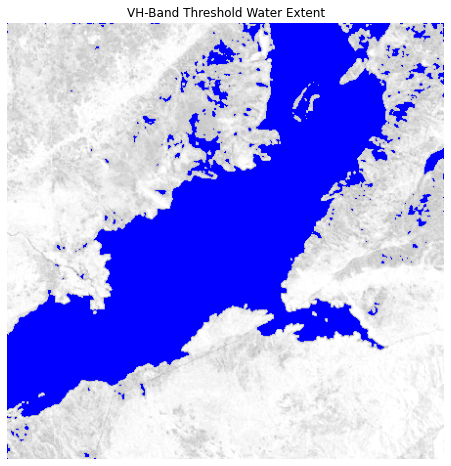

In [26]:
rgb(scene, bands=['vh', 'vh', 'vh'], paint_on_mask=[(water, color_blue)], width=8, min_inten=0.6)
plt.title('VH-Band Threshold Water Extent')
plt.axis('off')
plt.show()

### Time Series Water Extent

In [27]:
water_time = ((sar_dataset[single_variable] < water_threshold))

In [28]:
out = []
for obj in water_time:
    total = obj.values.sum()*100/1000/1000
    day = [total]
    out.append(day)

In [29]:
water_pixels = out
scene = sar_dataset.time.dt.date.values

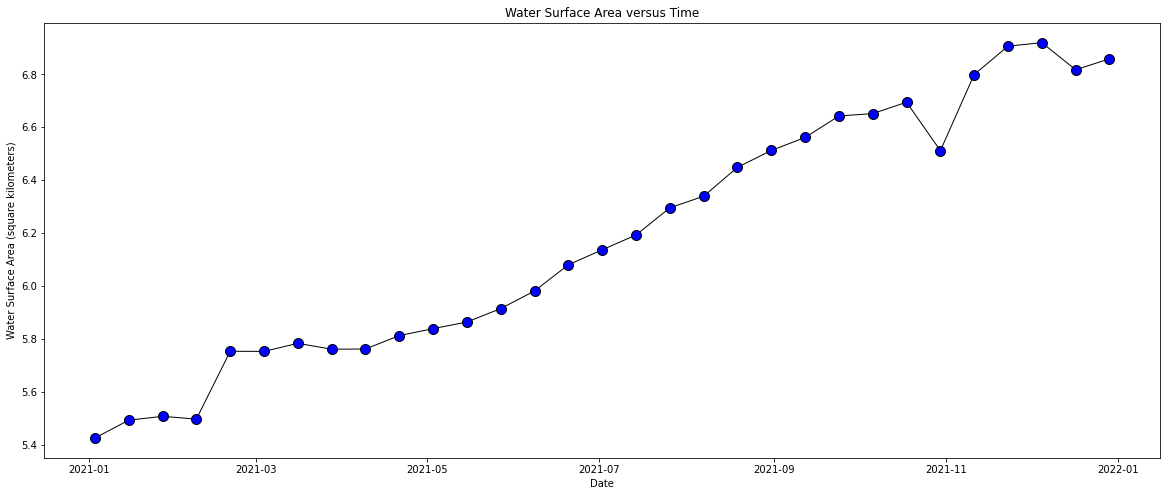

In [30]:
plt.figure(figsize=(20,8))
plt.plot(scene, water_pixels, c='black', marker='o', mfc='blue', markersize=10, linewidth=1)
plt.title('Water Surface Area versus Time')
plt.xlabel('Date')
plt.ylabel('Water Surface Area (square kilometers)')
plt.show()

### Water History (WOFS equivalent)

In [31]:
water_classification_percentages = (sar_dataset[single_variable] < water_threshold).mean(dim='time')*100

In [32]:
# import color-scheme and set nans (no data) to black
from matplotlib.cm import jet_r, terrain_r, gist_ncar_r
jet_r.set_bad('black',1)
terrain_r.set_bad('black',1)
gist_ncar_r.set_bad('black',1)

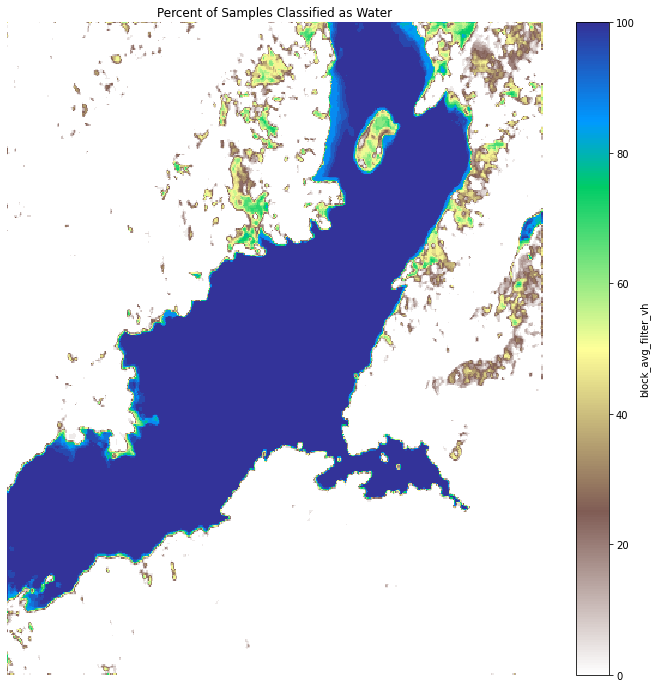

In [33]:
# This is where the WOFS time series product is generated. 
# Areas of RED have experienced little or no water over the time series
# Areas of BLUE have experience significant or constant water over the time series

water_classification_percentages.plot(cmap = terrain_r, figsize=(12,12))
plt.title("Percent of Samples Classified as Water")
plt.axis('off')
plt.show()